In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import create_ER, dataset_nclass_ER
from models import GCN, GCNEmbed
from train import Trainer, Dataset
from embedding import Embedding
from experiments import experiment_embedding

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats

import yaml

In [3]:
config = yaml.safe_load(open("configs.yml"))

In [4]:
dataset_grafi_nx, dataset_labels, list_p= dataset_nclass_ER(config)

Mean connectivity for each node: 9.939 p=0.05
Mean connectivity for each node: 39.789 p=0.2
Mean connectivity for each node: 59.679 p=0.3
Mean connectivity for each node: 79.612 p=0.4
Mean connectivity for each node: 99.513 p=0.5
Mean connectivity for each node: 119.392 p=0.6


In [5]:
#config = yaml.safe_load(open("configs.yml"))

embeddings, trainer = experiment_embedding(config, dataset_grafi_nx, dataset_labels, list_p)

GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 32)
    (3): GCNConv(32, 1)
  )
  (leaky): LeakyReLU(negative_slope=0.03)
)
MSELoss()
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████| 3000/3000 [03:52<00:00, 12.91it/s]


Tempo impiegato: 233.2720491886139
<class 'list'>
runs/lr-0.005_epochs150_bs150_neurons[1, 64, 64, 32, 1]/30May_00-04-50
Epoch: 5	Test loss: 0.00022482498445444636
Epoch: 10	Test loss: 0.0002381777928935157
Epoch: 15	Test loss: 0.00022415262543492846
Epoch: 20	Test loss: 0.00022526837264498075
Epoch: 25	Test loss: 0.0002239775305820836
Epoch: 30	Test loss: 0.00022576247652371725
Epoch: 35	Test loss: 0.0002232933251394166
Epoch: 40	Test loss: 0.00022675794238845507
Epoch: 45	Test loss: 0.00022383780322141118
Epoch: 50	Test loss: 0.00021831791020101972
Epoch: 55	Test loss: 0.00018818000331521033
Epoch: 60	Test loss: 6.846538641386562e-05
Epoch: 65	Test loss: 5.382541256646315e-05
Epoch: 70	Test loss: 2.9017451064040262e-05
Epoch: 75	Test loss: 1.0657247104164628e-05
Epoch: 80	Test loss: 9.566524531692267e-06
Epoch: 85	Test loss: 9.754093803672327e-06
Epoch: 90	Test loss: 9.10006217762e-06
Epoch: 95	Test loss: 8.337181190856628e-06
Epoch: 100	Test loss: 8.826542180031538e-06
Epoch: 105	Te

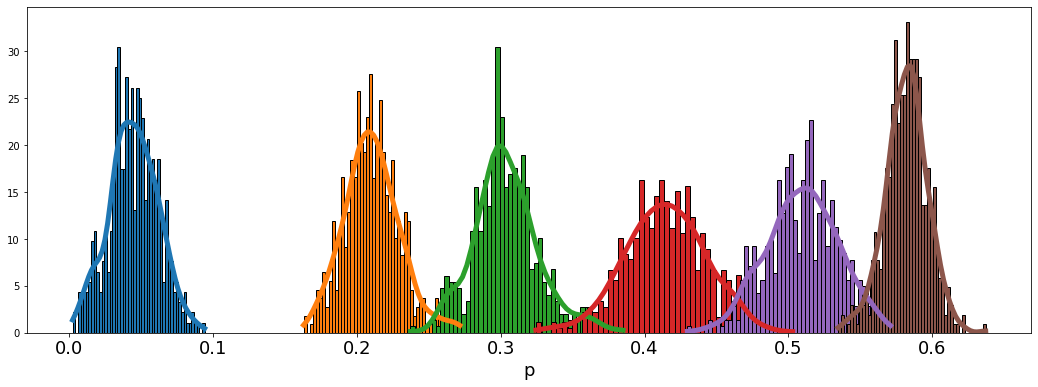

In [6]:
plt.figure(figsize=(18, 6)) #, dpi=60)
for p in list_p:
    mask_int = np.argwhere(embeddings.embedding_labels==p).flatten()
    emb = embeddings.embeddings_array[mask_int].flatten()
    
    h,e = np.histogram(emb, bins=50, density=True)
    x = np.linspace(e.min(), e.max())
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

    kde = stats.gaussian_kde(emb)
    plt.plot(x, kde.pdf(x),  lw=5, label='KDE')
    
plt.xlabel('p', fontsize=18)
plt.xticks(fontsize=18) 
plt.show()

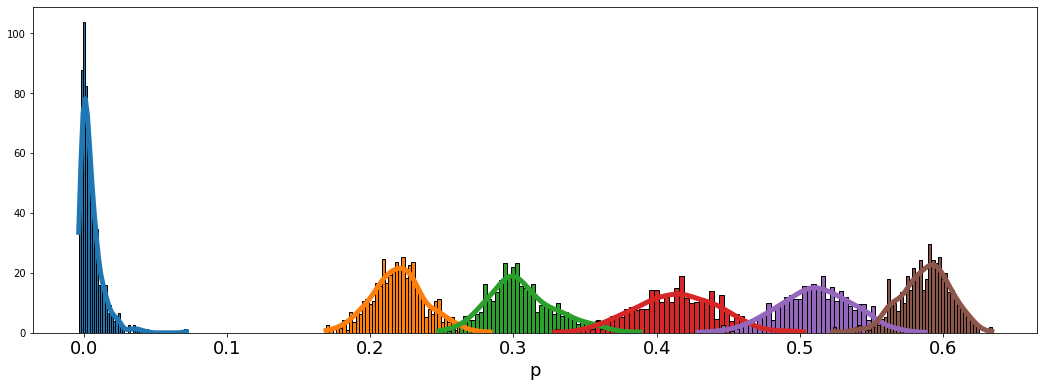